In [76]:
import numpy as np
from scipy.interpolate import splrep, splev
from scipy.optimize import minimize
import inspect 

def clean_knots(x,knots):
    '''This function cleans an array of knots, removing those where
    no element of x is present
    '''
    h = np.histogram(x,bins=knots)[0]
    sel = np.concatenate(([False], h>0))
    sel[-1] = False
    return(knots[sel])


class FiniteSizeScaling():
    ''' This class groups methods to do finite-size scaling of x (Nx3 or Nx4), 
        where columns are x_i, y_i, (dy_i), L_i, and expected law 
        y_i = f(map(x_i)).
        
        inputs: 
            x : array of N elements or Nx3, Nx4 matrix with columns corresponding to x_i,y_i
            y:
            dy:
            L: 
            mapx: 
    '''
    def __init__(self, x, y = None,  L = None, dy = None, mapx = None, ncoef = 2):
        # Checks for x and y should be here
        
        # Check for repeated xs
        
        # If all the data is in x:
        if y is  None:
            self.x = x[:,0]
            self.N = self.x.shape[0]
            self.y = x[:,1] 
            self.L = x[:,-1]
            if x.shape[1]>3:
                self.wy = 1.0/x[:,2]
            else:
                self.wy = np.ones(self.N)
        else:
            self.x = np.array(x)
            self.N = self.x.shape[0]
            self.y = np.array(y)
            if L is None:
                print('No sizes were given!')
                raise ValueError
            else:
                self.L = np.array(L)
            if dy is None:
                self.wy = np.ones(self.N)
            else:
                self.wy = 1.0/np.array(dy)
                
        if inspect.isfunction(mapx):
            self.mapx = mapx
        else:
            self.mapx = self.transform0
        
        self.ncoef = ncoef
        self.coefs = np.zeros(self.ncoef)
        self.xscaled = np.zeros((self.N,4))
        self.minx = None
        
#     def prefit(self, coefs0 = None):
#         ''' Preparing the dataset with coefficients coefs0, sorting 
#             and avoiding repeated points
#         '''
#         xscaled = self.mapx(coefs0)
#         if len(set(xscaled[:,0]))<self.N:
#             print('Warning: repeated x_i,L_i!')
#         xscaled[:,0] = xscaled[:,0]*(1.0+np.random.randn(self.N)*1e-8)
#         sel = xscaled[:,0].argsort()
#         self.xscaled = xscaled[sel,:]
#         return self.xscaled
    
    def prefit(self, coefs0 = None, selection = None):
        ''' Preparing the dataset with coefficients coefs0, sorting 
            and avoiding repeated points
        '''
        xscaled = self.mapx(coefs0)
        if len(set(xscaled[:,0]))<self.N:
            print('Warning: repeated x_i,L_i!')
        xscaled[:,0] = xscaled[:,0]*(1.0+np.random.randn(self.N)*1e-8)
        if selection is None:
            sel = xscaled[:,0].argsort()
            xscaled = xscaled[sel,:]
            self.xscaled = xscaled[sel,:]
        else:
            xscaled = xscaled[selection,:]
            sel = xscaled[:,0].argsort()
            xscaled = xscaled[sel,:]
            
        return xscaled
    
    def fit(self,coefs0 = None,nknots = 21):
        value = self.prefit(coefs0)
        #if value!=0:
        #    print('Error preparing the data!')
        #    raise RuntimeError
            
        minx = self.findscaling(coefs0,21)
        print(minx)

        self.xscaled = self.mapx(minx.x)
        return
    
    def errorbars_bootstrap(self,n_coef = None):
        print('Not implemented yet')
        pass
        return
    
    def plot_scaleddata(self,ax = None, nknots = 0, figsize = (7,5), **kwargs):
        if ax is None:
            fig = plt.figure(figsize = figsize )
            ax  = fig.add_subplot(111)
            
        xscaled = self.prefit(self.minx.x)
        for Lp in set(self.L):
            sel = xscaled[:,-1]==Lp
            xt = xscaled[sel,:2]
            xt.sort(axis=0)
            ax.plot(xt[:,0],xt[:,1],'.-',label=Lp,**kwargs)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.legend()
        if nknots >3 :
            ysp, _, _, _ = self.createspline(xscaled, nknots = nknots)
            xs = np.linspace(xscaled[:,0].min(),xscaled[:,0].max(), 101)
            ax.plot(xs,splev(xs,ysp),'k', linewidth = 2.5)
        return fig, ax
    
    def createspline(self, x, nknots = 21):
        xtx,xty,xwy = x[:,0],x[:,1],x[:,2]
        knots = np.linspace(min(xtx)+1e-6,max(xtx)-1e-6,11)
        knots = clean_knots(xtx,knots)
        try:
            yspl,f2,ie,ms = splrep(xtx,xty,t=knots,
                                   k=3,full_output=1, w= xwy)
        except Exception as e:
            print('Exception building splines:', e)
            
        return yspl, f2, ie, ms
        
    def findscaling(self,coefs0 = None, nknots = 21):  
        ''' Method to find the scaling, we define a chi2 function and minimize it
           nknots: number of knots for the cubic B spline function
        '''
        def chi2(cf):
            xscaled = self.prefit(cf)
            yspl, f2, ie, ms = self.createspline(xscaled, nknots)
            if ie>0:
                print('Exception but not raised!', ie,ms)
            return f2 #,ie,ms
        
        #print(coefs0, chi2(coefs0))
        try:
            minx = minimize(chi2,coefs0,method = 'Nelder-Mead', options = {'maxiter': 10000})
        except Exception as e: 
            print("Exception: ",e)
            return
        print(minx)
        self.minx = minx
        ie = self.prefit(minx.x)
        return(minx)
        
    def bootstrap(self, nbts = 100, nknots = 21, full=False):
        '''Estimate of error bars through bootstrap without error bars
        '''
        def chi2g(cf, selection):
            xscaled = self.prefit(cf, selection = selection)
            yspl, f2, ie, ms = self.createspline(xscaled, nknots)
            if ie>0:
                print('Exception but not raised!', ie,ms)
            return f2 #,ie,ms
        
        if self.minx is None:
            minx = self.findscaling(nknots)
            
        coefs0 = self.minx.x
        cfarray = np.zeros((nbts,coefs0.shape[0]))
        for i in range(nbts):
            selA = np.random.randint(self.N, size = self.N)
            try:
                minx = minimize(lambda x: chi2g(x,selA),coefs0,method = 'Nelder-Mead', 
                                options = {'maxiter': 500})
            except Exception as e: 
                print("Exception Bootstrap: ",e)
            cfarray[i,:] = minx.x
        
        if full:
            output = cfarray
        else:
            output = np.column_stack((cfarray.mean(axis = 0),cfarray.std(axis = 0)))
        return output
    
    def transform0(self,coefs):
        ''' Basic transformation of the data'''
        xscaled = np.zeros((self.N,4))
        xscaled[:,0] = (self.x-coefs[0])*self.L**coefs[1]
        xscaled[:,1] = self.y
        xscaled[:,2] = self.wy
        xscaled[:,3] = self.L
        return(xscaled)
    
#     def prefit(self, coefs0 = None, selection = None):
#         ''' Preparing the dataset with coefficients coefs0, sorting 
#             and avoiding repeated points
#         '''
#         xscaled = self.mapx(coefs0)
#         if selection is not None:
#             xscaled = xscaled[sel,:]
#         if len(set(xscaled[:,0]))<self.N:
#             print('Warning: repeated x_i,L_i!')
#         xscaled[:,0] = xscaled[:,0]*(1.0+np.random.randn(self.N)*1e-8)
#         if selection is None:
#             sel = xscaled[:,0].argsort()
#             xscaled = xscaled[sel,:]
#             self.xscaled = xscaled[sel,:]
#         else:
#             xscaled = xscaled[selection,:]
#             sel = xscaled[:,0].argsort()
#             xscaled = xscaled[sel,:]
            
#         return xscaled

In [77]:
import matplotlib.pylab as plt
%matplotlib inline

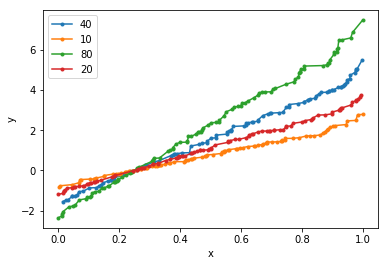

In [78]:
npt = 100
nL = 4
xs = np.random.rand(npt*nL)
Ls = 10*2**(np.arange(npt*nL)//npt)
ys = ((xs-0.25)*Ls**0.5)*(1.0+np.random.randn(xs.shape[0])*0.1)
for L in set(Ls):
    sel = Ls==L
    xt = np.column_stack((xs[sel],ys[sel]))
    xt.sort(axis=0)
    plt.plot(xt[:,0],xt[:,1],'.-',label=L)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [79]:
datafss = FiniteSizeScaling(xs,ys,Ls,ys*0.0+0.01)

In [80]:
datafss.xscaled.shape


(400, 4)

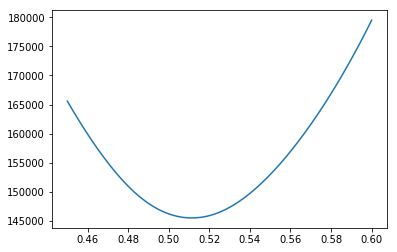

In [81]:
coefs0 = np.array([0.25,0.55])
chi2 = np.zeros(51)
y2s = np.linspace(0.45,0.6,51)
for i, y2 in enumerate(y2s):
    coefs0[1] = y2
    xt = datafss.prefit(coefs0)
    #plt.plot(xt[:,0],xt[:,1],'.')
    xtx,xty,xwy = xt[:,0],xt[:,1],xt[:,2]
    knots = np.linspace(min(xtx)+1e-6,max(xtx)-1e-6,21)
    knots = clean_knots(xtx,knots)
    yspl,f2,ie,ms = splrep(xtx,xty,t=knots,
                           k=3,full_output=1, w= xwy)
    #print(f2,ie)
    chi2[i] = f2
plt.plot(y2s,chi2)

In [82]:
coefs0 = np.array([0.1,0.5])
datafss.fit(coefs0,nknots = 11)

 final_simplex: (array([[0.24991682, 0.49781775],
       [0.24991682, 0.49781775],
       [0.24991682, 0.49781775]]), array([171184.58857988, 171184.59872207, 171184.60027939]))
           fun: 171184.5885798818
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 26610
           nit: 10000
        status: 2
       success: False
             x: array([0.24991682, 0.49781775])
 final_simplex: (array([[0.24991682, 0.49781775],
       [0.24991682, 0.49781775],
       [0.24991682, 0.49781775]]), array([171184.58857988, 171184.59872207, 171184.60027939]))
           fun: 171184.5885798818
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 26610
           nit: 10000
        status: 2
       success: False
             x: array([0.24991682, 0.49781775])


(<Figure size 504x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fca86e49490>)

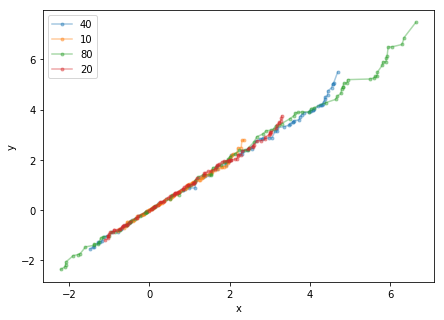

In [83]:
datafss.plot_scaleddata(alpha = 0.4)


In [85]:
datafss.bootstrap(nbts= 100, nknots= 11)

array([[0.25026997, 0.00314407],
       [0.50087057, 0.01435194]])

In [86]:
full = datafss.bootstrap(nbts= 100, nknots= 11, full=True)

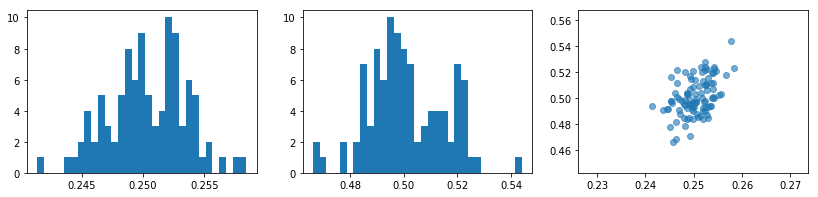

In [92]:
fig, ax = plt.subplots(1,3,figsize = (14,3))

ax[0].hist(full[:,0],bins=31)
ax[1].hist(full[:,1],bins=31)
ax[2].scatter(full[:,0],full[:,1],alpha=0.6)